In [1]:
import numpy as np
import webdataset as wds
import pandas as pd
import itertools

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/home/noams/Repositories/neurohelp-chronos-training/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
patient_names = ["pat_1307503"]
file_paths = [f"/innovation_cache/merged_eeg/{patient_name}.univariate.tar" for patient_name in patient_names]
# ds = wds.WebDataset(file_paths, shardshuffle=False).decode("l").to_tuple("segment.npy").map_tuple(lambda sample: {"target": sample.tolist(), "start": pd.Period("01-01-2019", freq='D')})
ds = wds.WebDataset(file_paths, shardshuffle=False).decode("l")


In [4]:
def generate_wds_to_tsdf(ds):
    """Generate webdataset to AutoGluon timeseries dataset."""
    for sample in ds:
        yield {"target": sample["segment.npy"].tolist(),
               "start": pd.Period("01-01-2019", freq=f'{int(1000000/4096)}us')}

In [5]:
iterable_dataset = list(itertools.islice(generate_wds_to_tsdf(ds), 5))

In [6]:
df = TimeSeriesDataFrame.from_iterable_dataset(iterable_dataset)

In [7]:
# data = TimeSeriesDataFrame.from_path(
#     "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
# )
data = df
data.head()

target
item_id timestamp                             
0       2019-01-01 00:00:00.000000  -79.719186
        2019-01-01 00:00:00.000244 -158.882484
        2019-01-01 00:00:00.000488 -138.565371
        2019-01-01 00:00:00.000732  -41.458132
        2019-01-01 00:00:00.000976    4.156368

In [8]:
81920/20

4096.0

In [9]:
prediction_length = 48 * 4
max_history_length = 200 * 4
finetune_time_limit = 240  # time limit in seconds
# model_preset = "bolt_small"
model_preset = "bolt_base"
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets=model_preset,
)

Beginning AutoGluon training...
AutoGluon will save models to '/home/noams/Repositories/neurohelp-chronos-training/notebooks/AutogluonModels/ag-20241231_155217'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #48~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  7 11:24:13 UTC 2
CPU Count:          28
GPU Count:          1
Memory Avail:       44.49 GB / 125.54 GB (35.4%)
Disk Space Avail:   451.87 GB / 937.33 GB (48.2%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 192,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}



Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


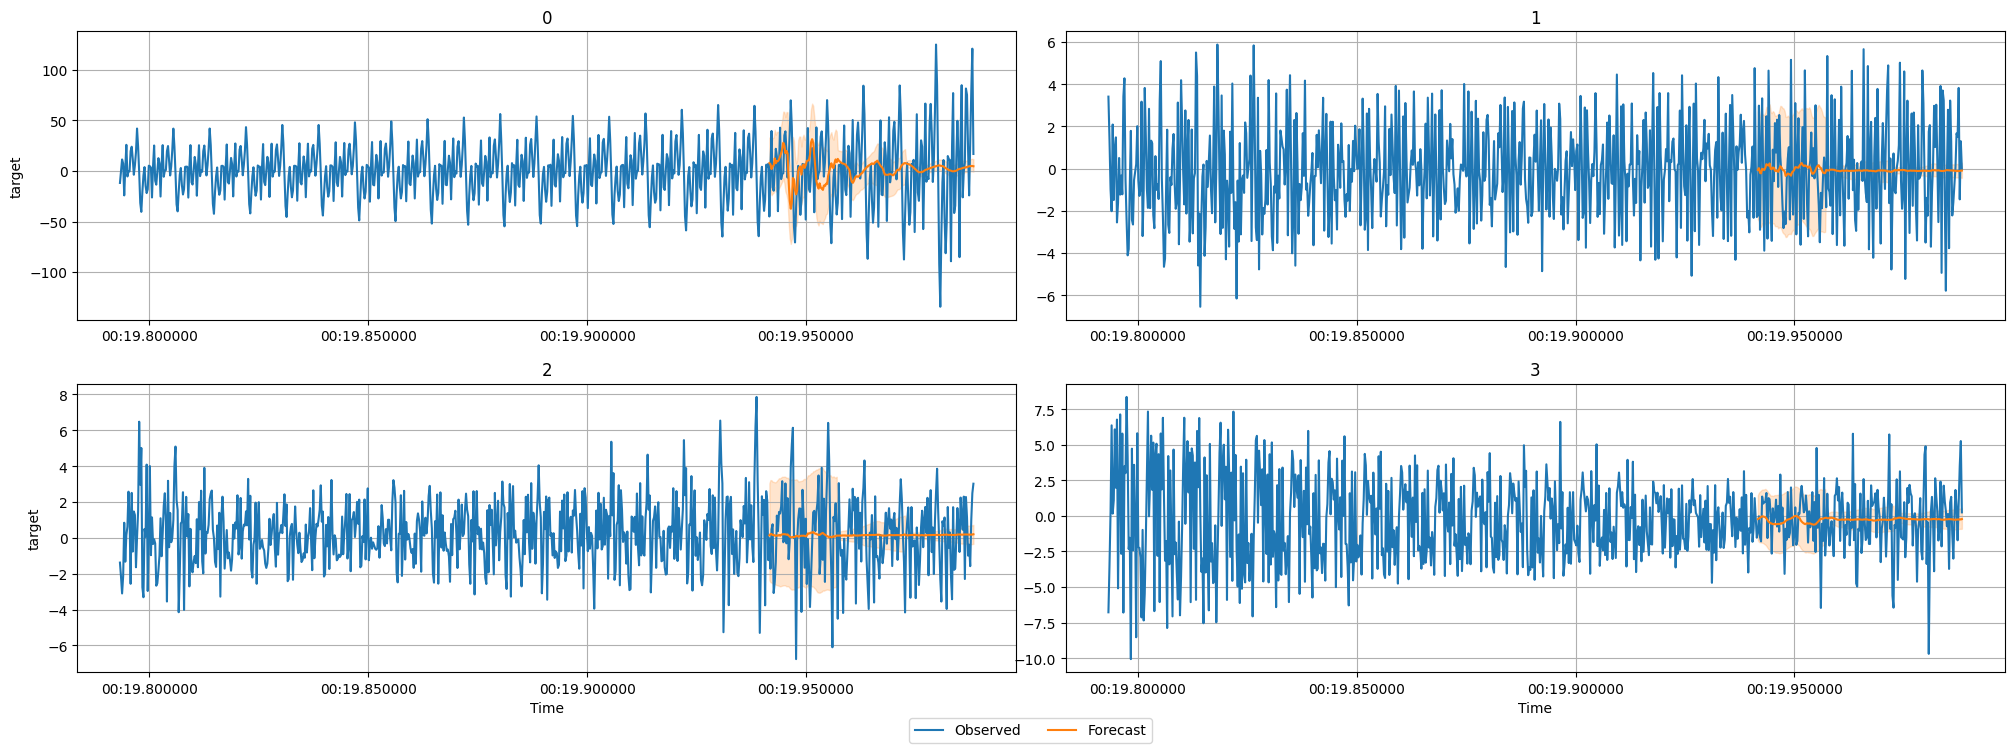

In [10]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:4],
    max_history_length=max_history_length,
);

## Finetuning

In [11]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": model_preset, "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": model_preset, "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=finetune_time_limit,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 240s
AutoGluon will save models to '/home/noams/Repositories/neurohelp-chronos-training/notebooks/AutogluonModels/ag-20241231_155222'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.9.20
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #48~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  7 11:24:13 UTC 2
CPU Count:          28
GPU Count:          1
Memory Avail:       43.95 GB / 125.54 GB (35.0%)
Disk Space Avail:   451.86 GB / 937.33 GB (48.2%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_base'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_base'}]},
 'known_covariates_names': [],
 'nu

In [12]:
predictor.leaderboard(test_data)


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_base],-0.458784,-0.391696,0.330184,0.071997,147.712552,2
1,ChronosZeroShot[bolt_base],-0.942232,-0.960445,1.132899,1.331481,0.090777,1


Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_base]


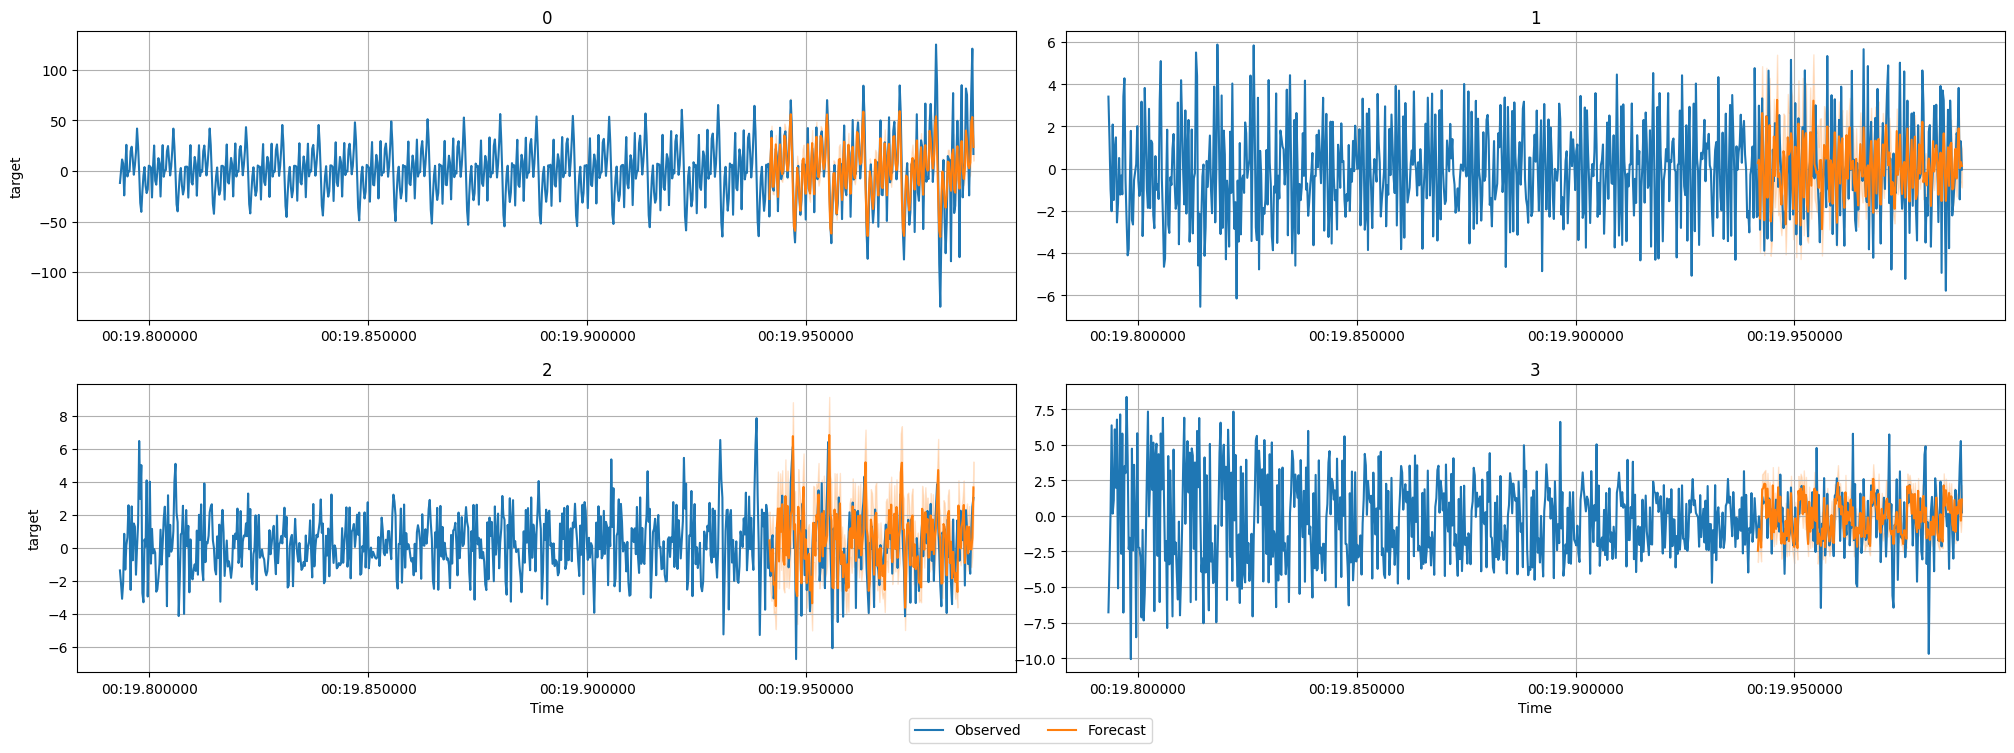

In [13]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:4],
    max_history_length=max_history_length,
)